In [1]:
import os
import scanpy as sc
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from matplotlib.colors import Normalize, TwoSlopeNorm
import matplotlib as mpl
import gseapy as gp
import seaborn as sns

In [2]:
figpath = '/stanley/WangLab/kamal/figures/projects/manifesto/interactions_human_lymph_node_tzonepca/'
os.makedirs(figpath, exist_ok=True)
dpi = 500

# Load

In [3]:
adata = sc.read_h5ad('/stanley/WangLab/kamal/data/technologies/xenium/human_lymph_node/filtered/adata.h5ad')

In [4]:
max_mag = 2

# Scale
sc.pp.scale(adata, layer='lowpass')
sc.pp.scale(adata, layer='highpass')

# Clip
X = adata.layers['lowpass']
X[X > max_mag] = max_mag
X[X < -max_mag] = -max_mag
X = adata.layers['highpass']
X[X > max_mag] = max_mag
X[X < -max_mag] = -max_mag

# Spatially arrange
adata.obsm['spatial'][:,1] *= -1

# Set figure size
width = adata.obsm['spatial'][:,0].ptp()
height = adata.obsm['spatial'][:,1].ptp()
set_width = 4
norm = set_width / width
sc.set_figure_params(figsize=(set_width, height*norm))

# T-zone-specific interactions (without division of else)

## Get regions

In [5]:
n_pcs = 10
pca = PCA(n_components=n_pcs, random_state=0)
adata.obsm['X_pca_lowpass'] = pca.fit_transform(adata.layers['lowpass'])
adata.varm['X_pca_lowpass'] = pca.components_.T

In [6]:
n_regions = 3
kmeans = KMeans(n_clusters=n_regions, random_state=0)
kmeans.fit(adata.obsm['X_pca_lowpass'])
adata.obs['region'] = kmeans.labels_.astype(str)

/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [7]:
regions = sorted(adata.obs['region'].unique())
colors = np.array(sc.pl.palettes.default_28)[[0,5,9]]
palette = {region:color for region,color in zip(regions,colors)}

adata.obs['is_paracortex'] = adata.obs['region'] == '1'
paracortex_colormap = {True: colors[1], False: [0.8]*3}
adata.obs['paracortex_color'] = adata.obs['is_paracortex'].map(paracortex_colormap)

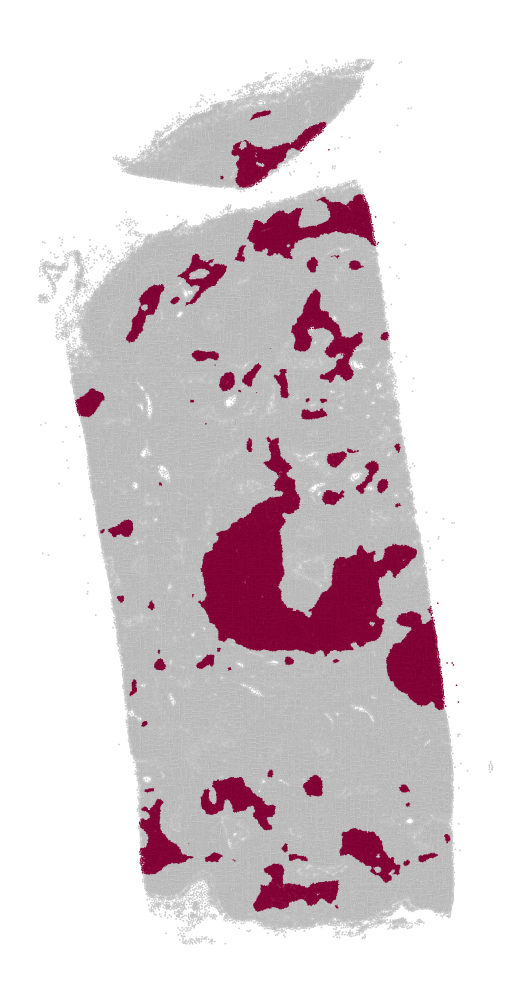

In [8]:
points = adata.obsm['spatial']
plt.figure(figsize=(4,8))
plt.scatter(
    points[:,0],
    points[:,1],
    edgecolor='k',
    linewidth=0.01,
    s=0.5,
    c=adata.obs['paracortex_color'],
)
plt.axis('off')
filename = os.path.join(figpath, 'paracortex.png')
# plt.savefig(filename, dpi=300)
plt.show()

## Interactions

In [9]:
def embed(adata, region, n_comps, filter_key):

    adata_region = adata[adata.obs['region']==region]
    adata_notregion = adata[adata.obs['region']!=region]

    X = adata_region.layers[filter_key]
    X -= X.mean(axis=0)
    A = X.T @ X

    # X_ = adata_notregion.layers[filter_key]
    # X_ -= X_.mean(axis=0)
    # B = X_.T @ X_

    w,V = eigh(A)#,B)
    w = w[::-1]
    V = V[:,::-1]

    V = V[:,:n_comps]
    adata.obsm[f'X_pca_{filter_key}'] = adata.layers[filter_key] @ V
    adata.varm[f'X_pca_{filter_key}'] = V
    adata.uns[f'comp_var_{filter_key}'] = w

    return V

### Paracortex

In [10]:
n_comps = 3
filter_key = 'highpass'
region = '1'

In [11]:
V = embed(adata, region, n_comps, filter_key)

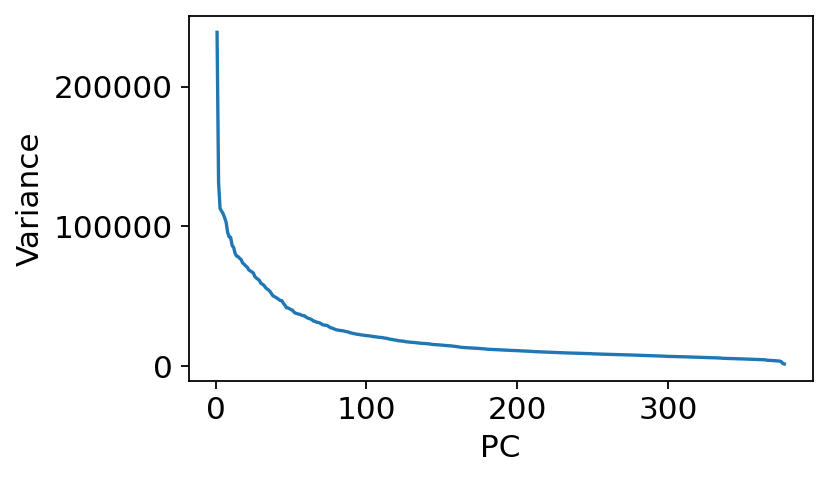

In [12]:
w = adata.uns[f'comp_var_{filter_key}']

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,len(w)+1), w)
plt.xlabel('PC')
plt.ylabel('Variance')
plt.grid(None)
plt.show()

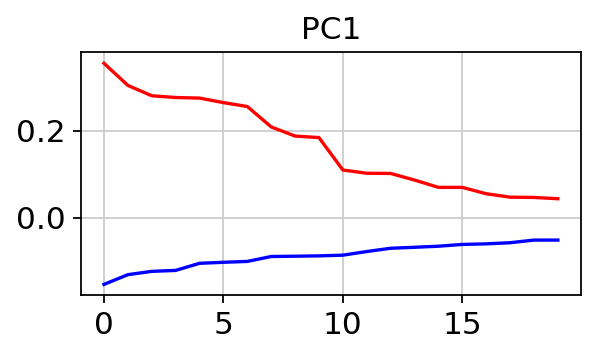

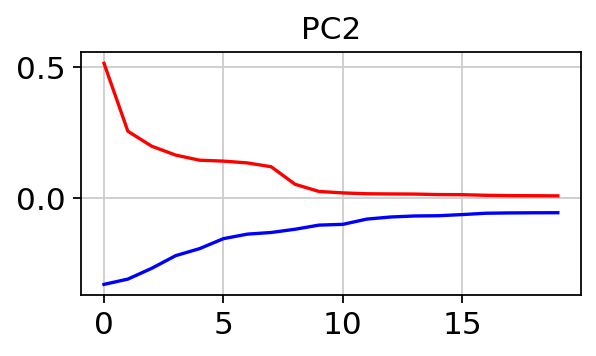

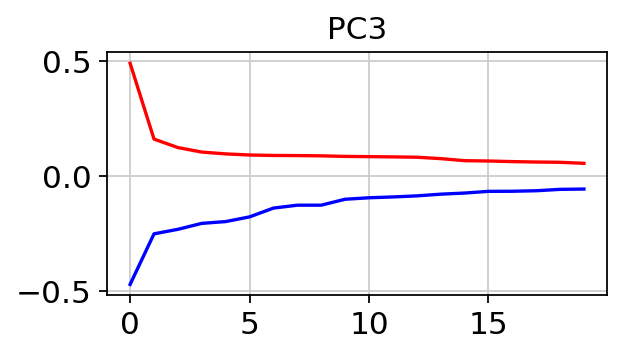

In [13]:
for i in range(n_comps):
    plt.figure(figsize=(4,2))
    plt.title(f'PC{i+1}')
    plt.plot(np.sort(adata.varm[f'X_pca_{filter_key}'][:,i])[::-1][:20], c='r')
    plt.plot(np.sort(adata.varm[f'X_pca_{filter_key}'][:,i])[:20], c='b')
    plt.show()

In [14]:
# Set figure size
width = adata.obsm['spatial'][:,0].ptp()
height = adata.obsm['spatial'][:,1].ptp()
set_width = 4
fignorm = set_width / width
sc.set_figure_params(figsize=(set_width, height*fignorm))

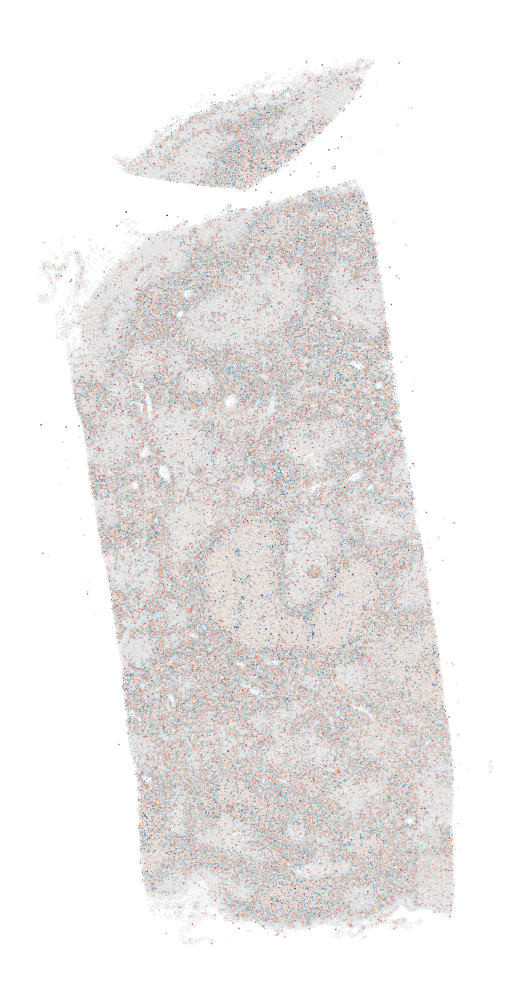

In [22]:
pc = 0
# adata.obs[f'PC{pc+1}'] = adata.obsm[f'X_pca_highpass'][:,pc]
c = adata.obsm['X_pca_highpass'][:,pc]
# norm = Normalize(vmin=-np.abs(c).max(), vmax=np.abs(c).max())
norm = TwoSlopeNorm(vcenter=0, vmin=c.min(), vmax=c.max())

points = adata.obsm['spatial']
plt.figure(figsize=(4,8))
plt.scatter(
    points[:,0],
    points[:,1],
    edgecolor='k',
    linewidth=0.005,
    s=0.5,
    c=c,
    cmap='RdBu_r',
    norm=norm,
)
plt.axis('off')
filename = os.path.join(figpath, f'ixn_tzone.png')
plt.savefig(filename, dpi=300)
plt.show()

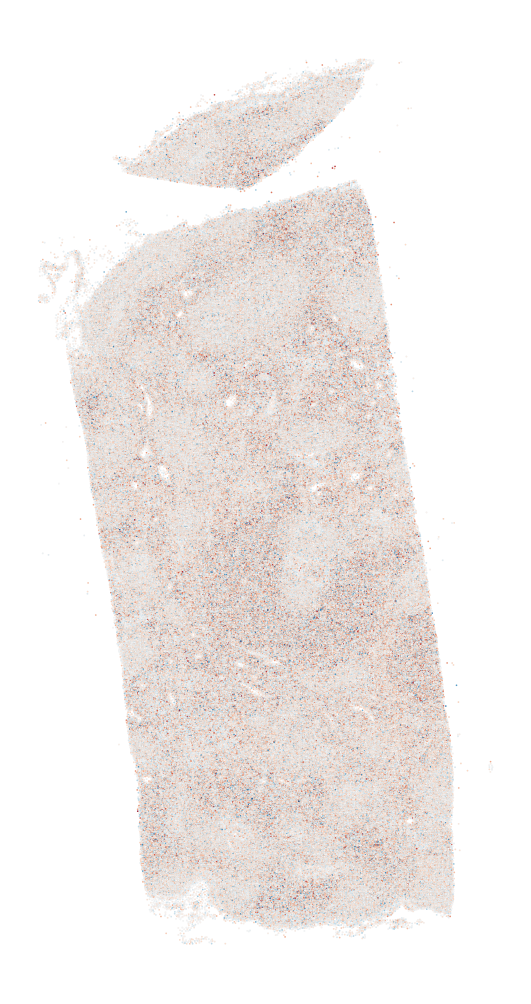

In [21]:
pc = 1
# adata.obs[f'PC{pc+1}'] = adata.obsm[f'X_pca_highpass'][:,pc]
c = adata.obsm['X_pca_highpass'][:,pc]
# norm = Normalize(vmin=-np.abs(c).max(), vmax=np.abs(c).max())
norm = TwoSlopeNorm(vcenter=0, vmin=c.min(), vmax=c.max())

points = adata.obsm['spatial']
plt.figure(figsize=(4,8))
plt.scatter(
    points[:,0],
    points[:,1],
    edgecolor='k',
    linewidth=0.005,
    s=0.5,
    c=c,
    cmap='RdBu_r',
    norm=norm,
)
plt.axis('off')
filename = os.path.join(figpath, f'ixn_tzone.png')
plt.savefig(filename, dpi=300)
plt.show()

In [16]:
# Set zoom dims
width = adata.obsm['spatial'][:,0].ptp()
height = adata.obsm['spatial'][:,1].ptp()
zoom_width = height/10
zoom_height = height/8

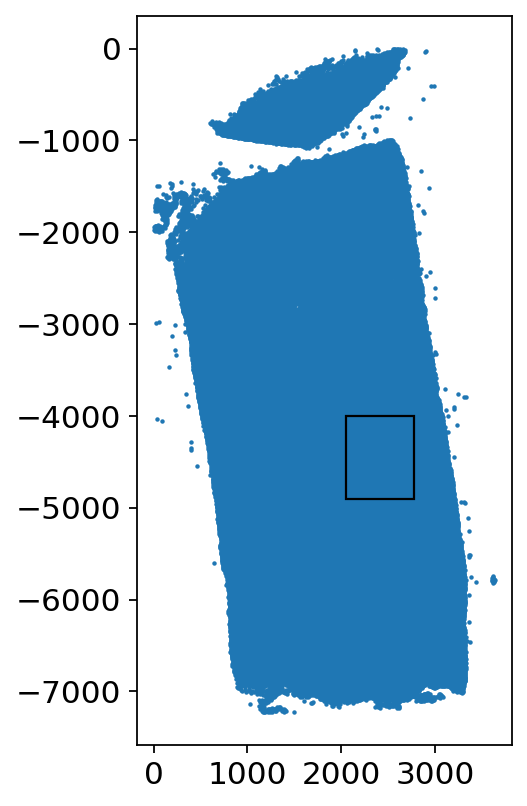

In [17]:
zoom_x = 2050
zoom_y = -4900

plt.figure(figsize=(3,6))
plt.scatter(*adata.obsm['spatial'].T, s=1)
rect = mpl.patches.Rectangle((zoom_x, zoom_y), zoom_width, zoom_height, edgecolor='k')
plt.gca().add_patch(rect)
plt.grid(None)
plt.show()

In [18]:
zdata = adata[adata.obsm['spatial'][:,0]>zoom_x]
zdata = zdata[zdata.obsm['spatial'][:,0]<zoom_x+zoom_width]
zdata = zdata[zdata.obsm['spatial'][:,1]>zoom_y]
zdata = zdata[zdata.obsm['spatial'][:,1]<zoom_y+zoom_height]

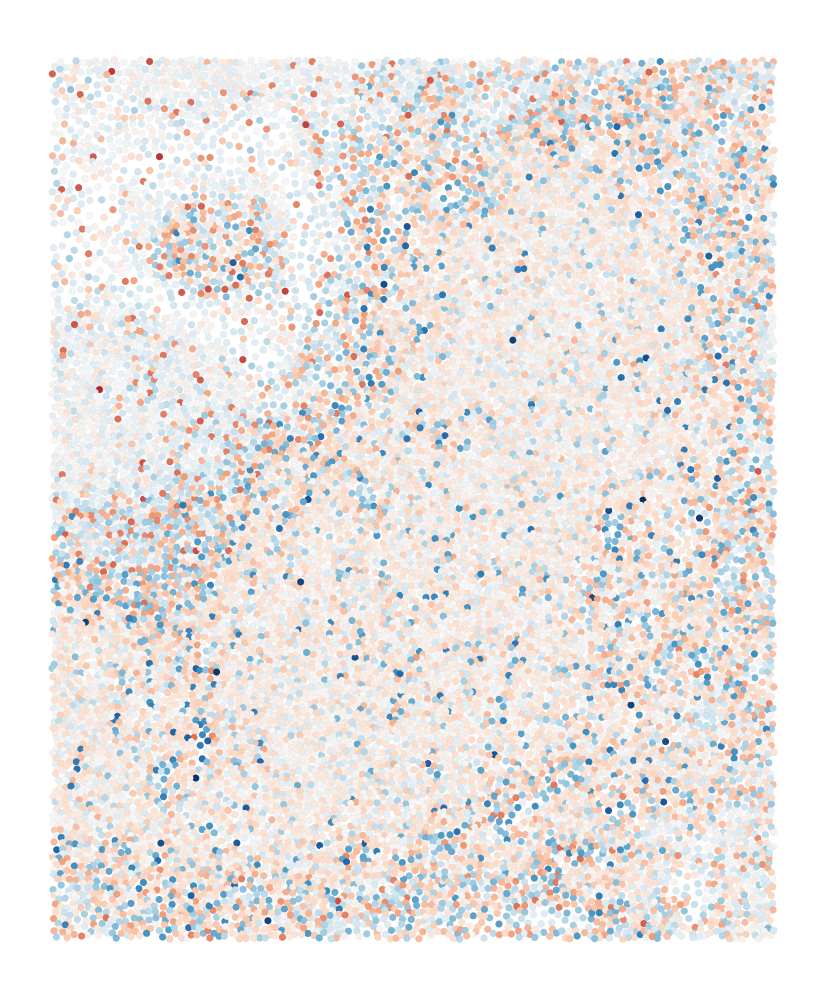

In [19]:
points = zdata.obsm['spatial']
plt.figure(figsize=(height*fignorm*(zoom_width/zoom_height), height*fignorm))
plt.scatter(
    points[:,0],
    points[:,1],
    edgecolor='k',
    linewidth=0.01,
    s=10,
    c=zdata.obsm['X_pca_highpass'][:,0],
    cmap='RdBu_r',
    norm=norm,
)
plt.axis('off')
filename = os.path.join(figpath, f'ixn_tzone_zoom.png')
plt.savefig(filename, dpi=300)
plt.show()

In [20]:
n_markers = 5
for i in range(n_comps):
    marker_idxs = np.argsort(adata.varm[f'X_pca_{filter_key}'][:,i])
    pos_marker_genes = adata.var_names[marker_idxs[::-1]][:n_markers]
    neg_marker_genes = adata.var_names[marker_idxs][:n_markers]

    print(f'========== PC{i+1} ==========')
    print('Positive markers: ', list(pos_marker_genes))
    print('Negative markers: ', list(neg_marker_genes))

========== PC1 ==========
Positive markers:  ['CD3D', 'CD3E', 'CD2', 'IL7R', 'CD28']
Negative markers:  ['PTGDS', 'MS4A1', 'IRF8', 'MPEG1', 'CCL19']
========== PC2 ==========
Positive markers:  ['CCR7', 'IL7R', 'CD8A', 'CD3E', 'CXCR4']
Negative markers:  ['CTLA4', 'CD28', 'CD4', 'CD2', 'PRDM1']
========== PC3 ==========
Positive markers:  ['CD2', 'CD8A', 'SELL', 'PRDM1', 'KLRB1']
Negative markers:  ['CD4', 'CD3D', 'CD28', 'CCR7', 'AIF1']
